# ASTR3110 Tutorial 6: Clustering with Gaussian Mixture Models

Tutorial 7 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand the basic Gaussian Mixture modelling technique.
 * Use the Scikit Learn clustering algorithm to find clusters in 2D data.
 * Test the behaviour GMM clustering with different assumptions.

## Setup

This week, we won't need to access any data on disk, so simply start a new *Python 3* notebook on Google Colab.The tutorial content is based on a section of the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas. Additional content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

## Introduction to GMMs

In this lectorial we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

As we saw in Week 6, given simple, well-separated data, *k*-means finds suitable clustering results.
One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.

In [1]:
# Import necessary modules and set plots to appear inline.
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs as blobs
from sklearn.cluster import KMeans
%matplotlib inline

In [37]:
# Generate some data using blobs from sklearn datrasets, as we did in Week 6. 
data, clusterID = blobs(n_samples=400, 
                       centers=4,
                       cluster_std=0.75, 
                       random_state=0)

# Swap X and Y axes for better plotting
data = data[:, ::-1] # flip axes for better plotting

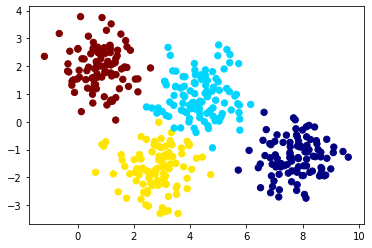

In [38]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
myKM = KMeans(n_clusters=4, random_state=0)
clusters = myKM.fit(data).predict(data)
plt.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='jet');

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [39]:
from scipy.spatial.distance import cdist

def plot_kmeans(myKM, data, n_clusters=4, rseed=0, ax=None):
    clusters = myKM.fit_predict(data)

    # Plot the input data
    ax = ax or plt.gca()#gca= get current axis (in case we are overplotting onto an exiting axis)
    ax.axis('equal')
    ax.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='jet', zorder=2)

    # Plot the representation of the KMeans model
    centers = myKM.cluster_centers_
    #Use cdist to determine the maximum radial extent of the data points allocated to each cluster.
    #cdist takes the x,y data points and measures distance from center
    radii = [cdist(data[clusters == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        #add_patch lets you add different shapes onto an image. Can add circles, ellipses, triangles etc.
        #fc=face colour, ec=edge colour, zorder tells order to plot. 
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', ec='k', lw=3, alpha=0.5, zorder=1))

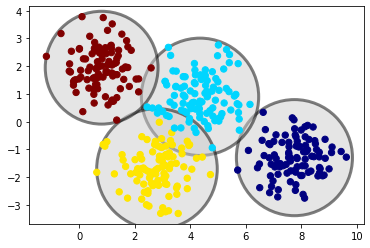

In [40]:
#run again with new plotting function
myKM = KMeans(n_clusters=4, random_state=0)
plot_kmeans(myKM, data)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

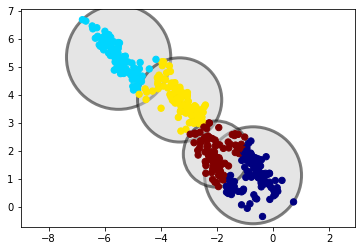

In [41]:
# Stretch the Y-axis
rng = np.random.RandomState(13)#initialise random number generator
dataLong = np.dot(data, rng.randn(2, 2))#generate 2x2 random normal that we can take the dot product of with 
                                        #the data to transform it into an elongated elliptical shape
#now, let's try running KMeans on this elongeted dataset.
myKM = KMeans(n_clusters=4, random_state=0)
plot_kmeans(myKM, dataLong)
#doesn't work real well!

## Generalizing Expectation–Maximisation: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

In [1]:
from sklearn.mixture import GaussianMixture as GMM
#GMM is called in exactly the same way as Kmeans, i.e., you need to set the number of components 
myGMM = GMM(n_components=4)
#then run the fit
myGMM.fit(data)
#and then you can use the predict method to label each data point with the 
#cluster that it has the highest probability of belonging to
clusters = myGMM.predict(data)

plt.scatter(data[:, 0], data[:, 1], c=clusters, s=40, cmap='jet');

NameError: name 'data' is not defined

In [2]:
GMM?

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [43]:
#we can get the probability that each data point belongs to a cluster as follows
probs = myGMM.predict_proba(data)
#this takes the first 5 datapoints and lists the probability associated with belonging to each cluster
print(probs[:5].round(3))
probs.shape

[[0.    0.008 0.    0.992]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.001 0.    0.    0.999]
 [1.    0.    0.    0.   ]]


(400, 4)

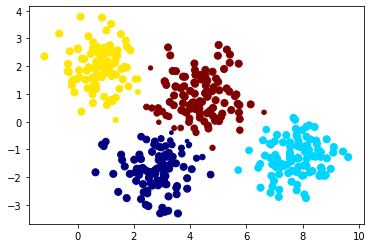

In [44]:
#can visualise this by plotting such that the size of the point is related to the 
#probability that a point belongs to a cluster
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='jet', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape of each Gaussian component (AKA cluster)

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [45]:
#this is similar to the above function that adds a circle to a plot, but is now
#generalised to an ellipse, which can have a set ellipticity and position angle
#that comes from the covariance.
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, covariance_type, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    
    ax = ax or plt.gca()#gca= get current axis (in case we are overplotting onto an exiting axis)
    
    # Convert covariance to principal axes
    if covariance_type == 'full':#shape == (2, 2):
        #the below three lines of code convert the covariance matrix to a position angle, 
        #and two lengths for the minor and major axis of the ellipse
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance_type == 'diag':
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    elif covariance_type == 'spherical':
        angle = 0
        width = 2 * np.sqrt(covariance)
        height = 2 * np.sqrt(covariance)
    # Draw ellipses at one-sigma, two-sigma and three-sigma.
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [46]:
#function that will take in gmm and data and make a scatterplot of data with ellipses overlaid
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        print(pos.shape, covar.shape)
        draw_ellipse(pos, covar, gmm.covariance_type, alpha=w * w_factor, ec='k')

(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)


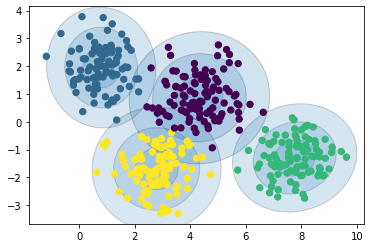

In [47]:
#rerun with our new plotting function
gmm = GMM(n_components=4, random_state=42)
gmm.fit(data)
plot_gmm(gmm, data)

In [48]:
#we can look at the mean positions of the 4 clusters:
for i in range(gmm.n_components):
    print('GMM Means for cluster ',i,'= ',gmm.means_[i,:])


GMM Means for cluster  0 =  [4.32967597 0.86240455]
GMM Means for cluster  1 =  [0.7931095  1.95030768]
GMM Means for cluster  2 =  [ 7.75982341 -1.30289395]
GMM Means for cluster  3 =  [ 2.78989379 -1.70183455]


In [49]:
#compare this with the means from above (note the ordering is different)
myKM = KMeans(n_clusters=4, random_state=0)
myKM.fit(data)
for i in range(myKM.n_clusters):
    print('KMeans Means for cluster ',i,'= ',myKM.cluster_centers_[i,:])

KMeans Means for cluster  0 =  [ 7.75224455 -1.29332753]
KMeans Means for cluster  1 =  [4.35151836 0.8982048 ]
KMeans Means for cluster  2 =  [ 2.80156612 -1.69994156]
KMeans Means for cluster  3 =  [0.80852994 1.94610509]


Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)


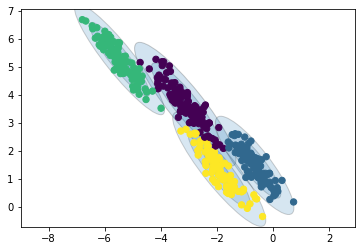

In [50]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, dataLong)
#gmm.bic(dataLong)

In [51]:
#check how thie centres compare here:
#we can look at the mean positions of the 4 clusters:
for i in range(gmm.n_components):
    print('GMM Means for cluster ',i,'= ',gmm.means_[i,:])


GMM Means for cluster  0 =  [-3.12638555  3.65931989]
GMM Means for cluster  1 =  [-0.65129083  1.47840888]
GMM Means for cluster  2 =  [-5.47054125  5.26070566]
GMM Means for cluster  3 =  [-1.91489179  1.3405662 ]


In [52]:
#compare this with the means from above (note the ordering is different)
myKM = KMeans(n_clusters=4, random_state=0)
myKM.fit(dataLong)
for i in range(myKM.n_clusters):
    print('KMeans Means for cluster ',i,'= ',myKM.cluster_centers_[i,:])

KMeans Means for cluster  0 =  [-0.70754111  1.12453647]
KMeans Means for cluster  1 =  [-5.50506703  5.33726227]
KMeans Means for cluster  2 =  [-3.32756031  3.81296098]
KMeans Means for cluster  3 =  [-2.01637648  1.88199771]


In [53]:
#We can also look at the 2x2 covariance arrays for each of the 4 clusters
#the terms on the diagonal give the size (variance = sigma**2) of each cluster in the x- and y-directions, 
#while the off-diagonal terms describe the covariance in x and y, i.e., they describe
#the angle of the ellipse.
for i in range(gmm.n_components):
    print('GMM Covariance for cluster ',i,'is ')
    print(gmm.covariances_[i,:])

GMM Covariance for cluster  0 is 
[[ 0.36358373 -0.39982525]
 [-0.39982525  0.54148132]]
GMM Covariance for cluster  1 is 
[[ 0.21785491 -0.23589564]
 [-0.23589564  0.34151398]]
GMM Covariance for cluster  2 is 
[[ 0.28593193 -0.32362804]
 [-0.32362804  0.43377437]]
GMM Covariance for cluster  3 is 
[[ 0.30620841 -0.33640444]
 [-0.33640444  0.46139518]]


### Choosing the covariance type

If you look at the details for Gaussian Mixture, you will see that the ``covariance_type`` option can be set to different types.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
Setting the ``covariance_type="diag"`` means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see how this works using our two example datasets:

(2,) ()
(2,) ()
(2,) ()
(2,) ()


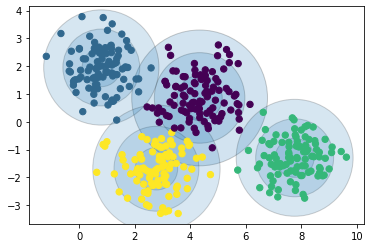

In [54]:
#for our original  blobs dataset, they look pretty circular and similar in size, so set covariance to spherical
gmm = GMM(n_components=4, covariance_type='spherical', random_state=42)
gmm.fit(data)
plot_gmm(gmm, data)

(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)


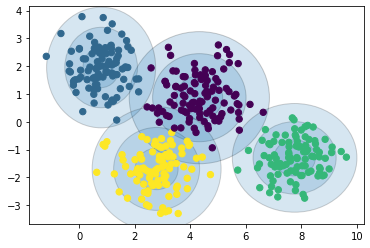

In [55]:
#if blobs have different sizee, but are circular, use diagonal.
gmm = GMM(n_components=4, covariance_type='diag', random_state=42)
gmm.fit(data)
plot_gmm(gmm, data)

(2,) ()
(2,) ()
(2,) ()
(2,) ()


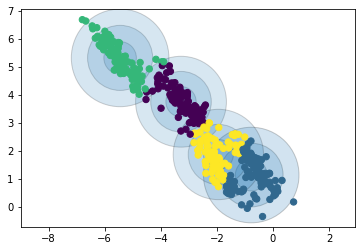

In [56]:
#but setting to diag or spherical does not do a good job for our long-axis datasest:
gmm = GMM(n_components=4, covariance_type='spherical', random_state=42)
gmm.fit(dataLong)
plot_gmm(gmm, dataLong)

(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)


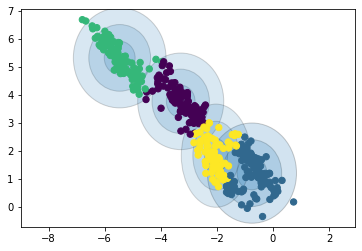

In [57]:
gmm = GMM(n_components=4, covariance_type='diag', random_state=42)
gmm.fit(dataLong)
plot_gmm(gmm, dataLong)

(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)


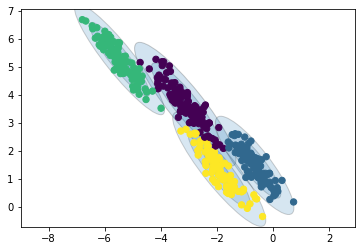

In [58]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
gmm.fit(dataLong)
plot_gmm(gmm, dataLong)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which generates crescent-moon shaped distribtutions:

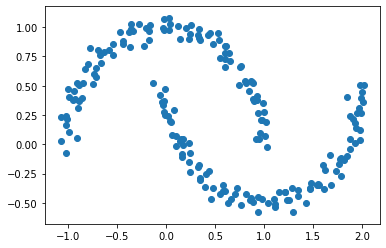

In [28]:
#If skipping the density part, need to run this for the BIC below.
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

(2,) (2, 2)
(2,) (2, 2)


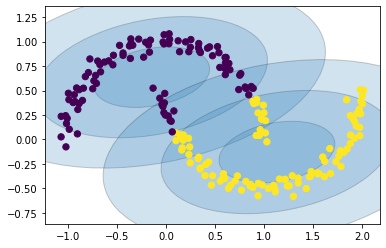

In [29]:
#try 2 components
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)


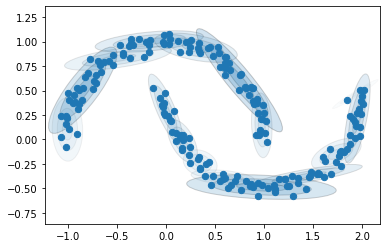

In [30]:
#try 16 components
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

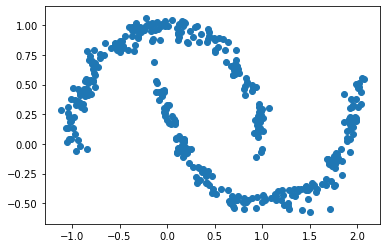

In [31]:
Xnew, labels = gmm16.sample(400)#, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

In [32]:
Xnew[1]

array([-0.79114795,  0.70198326])

### How many components?

In the Week 3 lectorial, we met the problem of trying to ascertain the optimum number of polynomial parameters that are required to fit the data. Optimal here meant that we want the minimum polynomial order that describes the data without over-fitting (i.e., fitting fluctuations caused by uncertainties in the data). 

We have a similar problem in attempting to understand how many clusters/components are required to oprtimally fit the data. Again, we can use the the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion), which includes the likelihood measured for the fit along with a term that penalises an increase in the number of components to avoid over-fitting. Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute BIC (and another information criteria called the Akike Information Criteria), and so it is very easy to operate on this approach.

Let's look at the BIC as a function as the number of GMM components for our moon dataset:

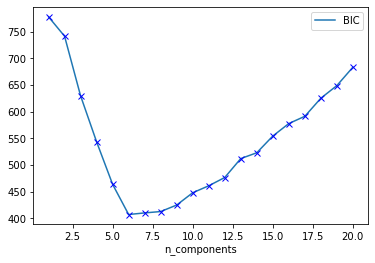

In [33]:
n_components = np.arange(1, 21)
BIC=[]
for i in np.arange(len(n_components)):
    gmm=GMM(n_components[i],covariance_type='full').fit(Xmoon)
    BIC.append(gmm.bic(Xmoon))
               
plt.plot(n_components, BIC, label='BIC')
plt.plot(n_components, BIC,'xb', label='')
plt.legend(loc='best')
plt.xlabel('n_components');

In [34]:
#we are interested in how the BIC changes in going from the less complicated to the more complicated model, i.e.,
#fewer to more components/clusters.
for i in np.arange(len(BIC)-1):
    print('Change in BIC going from component ',n_components[i],' to ',n_components[i+1],' = ',BIC[i+1]-BIC[i])

Change in BIC going from component  1  to  2  =  -36.33876556096425
Change in BIC going from component  2  to  3  =  -111.84426266123148
Change in BIC going from component  3  to  4  =  -86.36860945793387
Change in BIC going from component  4  to  5  =  -79.76027186519536
Change in BIC going from component  5  to  6  =  -56.61514371212013
Change in BIC going from component  6  to  7  =  2.9932414296208094
Change in BIC going from component  7  to  8  =  2.5745771221924656
Change in BIC going from component  8  to  9  =  12.212779439779922
Change in BIC going from component  9  to  10  =  23.06761740079895
Change in BIC going from component  10  to  11  =  13.048658084096814
Change in BIC going from component  11  to  12  =  15.548152522668488
Change in BIC going from component  12  to  13  =  35.52846315420004
Change in BIC going from component  13  to  14  =  10.893654051635394
Change in BIC going from component  14  to  15  =  31.38647477024938
Change in BIC going from component  15 

So, going from 5->6 components BIC decreases by 56.5, but from 6 -> 7 it *increases*. In general, to justify the more complicated model we want BIC to decrease with increasing model complexity (i.e., number of components/clusters), and the rule of thumb is that it must decrease by 6 or more to justify the increased number of components. So, here 6 looks to be the optimum number of components.

(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)
(2,) (2, 2)


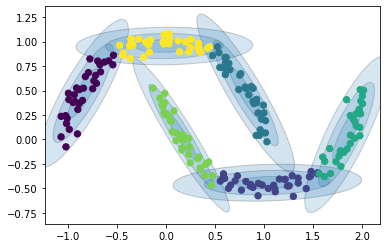

In [36]:
gmm6 = GMM(n_components=6, covariance_type='full', random_state=0)
plot_gmm(gmm6, Xmoon, label=True)